In [1]:

import sys 
sys.path.insert(1, "..")
from paseos import ActorBuilder, SpacecraftActor
import pykep as pk
import numpy as np
import paseos
#from paseos.visualization.space_animation import SpaceAnimation
from paseos.utils.set_log_level import set_log_level
from paseos.utils.load_default_cfg import load_default_cfg
from paseos.visualization.space_animation import SpaceAnimation
set_log_level("INFO")
%load_ext autoreload
%autoreload 2

14:00:16|PASEOS-DEBUG| Setting LogLevel to DEBUG
14:00:16|PASEOS-DEBUG| Loaded module.


In [2]:
# Define central body
earth = pk.planet.jpl_lp("earth")
# Defining today date as pk.epoch (27 - 10 - 22)
today=pk.epoch(8335.5, "mjd2000")

# 1) - Instantiate Sentinel 2 space actors

First of all, let's create the scaffolds for **Sentinel2-A (S2A)** and **Sentinel2-B (S2B)**. The scaffolds are objects which are not equipped with any `communication_device` nor `power_devices`. Furthermore, they neither have any `orbit`. 

In [21]:
S2A = ActorBuilder.get_actor_scaffold(
    "Sentinel2-A", SpacecraftActor, [0,0,0], today
)

# Define local actor
S2B = ActorBuilder.get_actor_scaffold(
    "Sentinel2-B", SpacecraftActor, [0,0,0], today
)

## 1.a) - Add an orbit for **S2A** and **S2B**

Since **S2A** and **S2B** are orbiting around Earth, let's define `earth` as `pykep.planet` object.

In [ ]:
# Define central body
earth = pk.planet.jpl_lp("earth")


To find a realistic orbits for **S2A** and **S2B**, we can exploit `Two Line Elements (TLEs)` (Downloaded on 27-10-2022). This would allow finding their ephemerides at time = 27-10-2022 12:00:00.

In [23]:
#Define today (27-10-22)
today = pk.epoch(8335.5,"mjd2000")

sentinel2A_line1 = "1 40697U 15028A   22300.01175178 -.00001065  00000+0 -38995-3 0  9999"
sentinel2A_line2 = "2 40697  98.5650  12.8880 0001080  78.8662 281.2690 14.30806819383668"
sentinel2A = pk.planet.tle(sentinel2A_line1, sentinel2A_line2)

#Calculating S2A ephemerides.
sentinel2A_eph=sentinel2A.eph(today)

sentinel2B_line1 = "1 42063U 17013A   22300.18652110  .00000099  00000+0  54271-4 0  9998"
sentinel2B_line2 = "2 42063  98.5693  13.0364 0001083 104.3232 255.8080 14.30819357294601"
sentinel2B = pk.planet.tle(sentinel2B_line1, sentinel2B_line2)

#Calculating S2B ephemerides.
sentinel2B_eph=sentinel2B.eph(today)


**S2A** and **S2B** are always in phase opposition. The next cell show the positions of the two satellites in different instants (`2022-Oct-27 12:00:00`, `blue`) and (`2022-Oct-27 12:19:59`, `red`). 

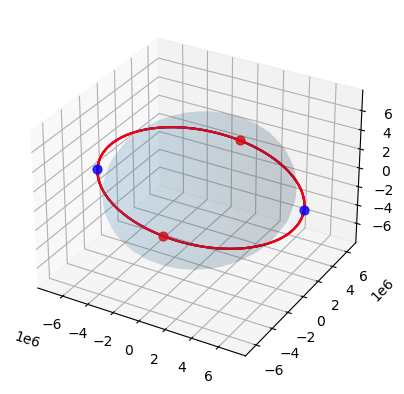

In [20]:
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:30j]
x = pk.EARTH_RADIUS * np.cos(u) * np.sin(v)
y = pk.EARTH_RADIUS * np.sin(u) * np.sin(v)
z = pk.EARTH_RADIUS * np.cos(v)
ax=pk.orbit_plots.plot_planet(sentinel2A,t0=today, color="b")
ax=pk.orbit_plots.plot_planet(sentinel2B,t0=today, axes=ax, color="b")
ax=pk.orbit_plots.plot_planet(sentinel2A,t0=pk.epoch(today.mjd2000 + 60 * 20 * pk.SEC2DAY), axes=ax, color="r")
ax=pk.orbit_plots.plot_planet(sentinel2B,t0=pk.epoch(today.mjd2000 + 60 * 20 * pk.SEC2DAY), axes=ax, color="r")
ax.plot_surface(x,y,z,alpha=0.1)

Since **S2A** and **S2B** are always in phase opposition, any communication between the satellites is impossible. Therefore, we will now set the **S2B** space actor orbit by inverting the direction of its speed. 

In [24]:
#Adding orbits around Earth based on previously calculated ephemerides
ActorBuilder.set_orbit(S2A, sentinel2A_eph[0], sentinel2A_eph[1], today, earth)

# To enable the communication between S2A and S2B, the velocity vector is multiplied by - 1 making the satellite to orbit with opposite direction.
ActorBuilder.set_orbit(S2B, sentinel2B_eph[0], [-sentinel2B_eph[1][0], -sentinel2B_eph[1][1],-sentinel2B_eph[1][2]], today, earth)

In [ ]:
## 1.b) - Add communication and power devices

Adding power devices. Max battery level: 102 Ah @ 28V is 2.81 kWh.  To identify the charging rate, we are assuming it is to be giving by power of solar panels. We are neglecting eventual charging rate limits due to battery technology. The solar-panels power affect charging rate. 2300 W at begin of life and 1730 W at end of life. <br> Please, refer to: https://www.eoportal.org/satellite-missions/copernicus-sentinel-2#space-segment.

In [25]:
ActorBuilder.set_power_devices(S2A, battery_level_in_Ws=500, max_battery_level_in_Ws=10080000, charging_rate_in_W=1736)
ActorBuilder.set_power_devices(S2B, battery_level_in_Ws=500, max_battery_level_in_Ws=10080000, charging_rate_in_W=1860)


Adding communication devices. Here we assume Sentinel 2A and Sentinel 2B to have an Inter-Satellite-Link at 100 Mbps.

In [ ]:
ActorBuilder.add_comm_device(S2A, "isl_transmitter", 100000)
ActorBuilder.add_comm_device(S2B, "isl_transmitter", 100000)

# 2) - Instantiate PASEOS simulation

To instantiate `PASEOS`, we consider **S2A** as `local_actor`. The initial time is set to `today`.

In [28]:
# init simulation
cfg=load_default_cfg()
cfg.sim.start_time=today.mjd2000 * pk.DAY2SEC
sim = paseos.init_sim(S2A, cfg)

We now add **S2B** to the simulation.

In [30]:
sim.add_known_actor(S2B)

a# init simulation
cfg=load_default_cfg()
cfg.sim.start_time=today.mjd2000 * pk.DAY2SEC
sim = paseos.init_sim(S2A, cfg)

asim.add_known_actor(S2B)

anim = SpaceAnimation(sim)

anim = SpaceAnimation(sim)
import matplotlib.pyplot as plt
dt = 100
for t in range(100):
    anim.animate(sim, dt)
    plt.pause(0.05)
plt.show()